In [1]:
#-*- coding:utf8-*-
%matplotlib inline

from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import Image

import numpy as np

import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 
import matplotlib.transforms as mtrans

import seaborn as sns
sns.set(context="paper",font_scale=1.4)
sns.set_context(rc={'lines.markeredgewidth': 0.1})
plot_colors = sns.color_palette()


import scipy as sp
import scipy.constants as const

import sympy as sym

import pandas as pd


from aputils.latextables.tables import Table

import sys

# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)

#Laden des Latex fonts 
plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

#Größe der Achsenbeschriftung
axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
path_table = "../Tabellen/"
path_data = "../Messdaten/"
path_results = "../Ergebnisse/"

/home/luckyjosh/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/luckyjosh/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [142]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return lable
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])

# Achsenskalierung
def axis_scale(factor, axis="x"):
    if axis == "x":
        plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    elif axis == "y":
        plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    else:
        print("Wrong axis name given! Only x and y are allowed!")

def siunitx_ticklabels(ax=None, locale="DE", xaxis=True, yaxis=True,
                       round_precision=2, round_mode="places", scale_x=None, scale_y=None):
    """
    This function uses siunitx to create the ticklabels
    Main reason is for adjusting the decimal marker properly.
    The function takes 4 arguments:
        ax=None     the matplotlib axes to operate on
                    if set to None (Standard) this will be the current axes
        locale="DE" The locale parameter for siunitx, one of
                    "UK", "US", "DE", "FR" oder "ZA"
        xaxis=True  Boolean, if True the labels for the xaxis are set
        yaxis=True  Boolean, if True the labels for the yaxis are set
        round_precision=2 Number of places or figures after rounding
        round_mode="places" Rounds to round_precision many decimal places,
                  "figures" Rounds to round_precision many significant figures
                  
    """

    if ax is None:
        ax = plt.gca()

    if scale_x == None:
        scale_x = 1
    if scale_y == None:
        scale_y = 1
        
        
    if xaxis is True:
        xticks = ax.get_xticks()
        print(xticks)
        xlabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,round_precision, tick*scale_x) for tick in xticks]
        #print(xlabels)
        ax.set_xticklabels(xlabels)

    if yaxis is True:
        yticks = ax.get_yticks()
        ylabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,round_precision, tick*scale_y) for tick in yticks]
        #print(ylabels)
        ax.set_yticklabels(ylabels)    
        
# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if "uncertainties" in str(type(array[0])):
        formatstring = "{:.1uS}"
    else:
        formatstring = "{}"
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = map(len,description)
        for entry,Len,desc in zip(array,lens,description):
            #print(desc," "*(maxlen-Len),entry.nominal_value,"+/-",entry.std_dev)
            print(desc," "*(maxlen-Len),formatstring.format(entry))
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)
    print("")
    
def _print_result(result,sym=None,unit=None,file=sys.stdout):
    if "uncertainties" in str(type(result)):
        formatstring = "{:.1uS}"
    else:
        formatstring = "{{}}"
    if sym == None:
        sym = ""
        eqstring="{}"
    else:
        eqstring="{} = "
    if unit == None:
        print(eqstring.format(sym),"\\num{{{}}}".format(formatstring).format(result),file=file)
    else:
        print(eqstring.format(sym),"\\SI{{{}}}{{{}}}".format(formatstring,"{{}}").format(result,unit),file=file)
        
def print_result(result, sym=None, unit=None, file=None, mode="w"):
    if file == None:
        _print_result(result, sym, unit=unit)
    else:
        with open(path_results+file, mode) as File:
            _print_result(result, sym, unit=unit, file=File)

In [133]:
a = [1,2,3,4]
b = [0.1,0.2,0.5,0.1]

c = unp.uarray(a,b)
d = unp.uarray(b,a)
e = c*d
print(e[0],"uncertainties" in str(type(e[0])))


0.1+/-1.0 True


In [3]:
def lighten_color(color_rgb, amount):
    def calc_new(value,amount):
        new_value = value + amount
        if new_value >1:
            new_value = 1
        elif new_value < 0:
            new_value = 0
        return new_value
    
    new_color = tuple([calc_new(val,amount) for val in color_rgb])
    return new_color
        
    

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.5058823529411764, 0.4470588235294118, 0.6980392156862745), (0.8, 0.7254901960784313, 0.4549019607843137), (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]


/home/luckyjosh/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


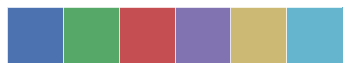

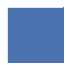

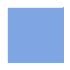

In [4]:
print(sns.color_palette())
sns.palplot(sns.color_palette())
sns.palplot([(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)])
sns.palplot([lighten_color((0.2980392156862745, 0.4470588235294118, 0.6901960784313725),0.2)])

## Auswertung Resonanzstellen

In [56]:
def magnetic_field_coil(N,R,I):
    return const.mu_0 * (8*I*N/(np.sqrt(125)*R))

In [57]:
# Spulenparameter N:Windungszahl, R:Radius
coil_sweep = {"N":11, "R":0.1639}
coil_horizontal = {"N":154,"R":0.1579}
coil_verttical = {"N":20,"R":0.11735}

magnetic_field_frequence_factor = 4*np.pi*(const.electron_mass/const.e)

In [58]:
# Resonanzstellen für die beiden Isotope P1=Rb87, P2=Rb85
resonance_positions = pd.read_csv(path_data+"Resonanzsstellen.csv")

In [59]:
resonance_positions.head(5)

,Frequenz kHz,SweepStrom P1 0.1V,HorizontalStrom P1 0.3V,SweepStrom P2 0.1V,HorizontalStrom P2 0.3V
0,100,5.61,0.00,6.80,0.00
1,200,5.79,0.05,8.14,0.05
2,300,2.81,0.17,6.39,0.17
3,400,1.74,0.25,6.49,0.25
4,500,1.99,0.30,7.87,0.30


In [60]:
# Fehlerbehaftete Größen
resonance_positions["SweepStrom P1 0.1V"] = unp.uarray(resonance_positions["SweepStrom P1 0.1V"],[0.01])
resonance_positions["HorizontalStrom P1 0.3V"] = unp.uarray(resonance_positions["HorizontalStrom P1 0.3V"],[0.01])
resonance_positions["SweepStrom P2 0.1V"] = unp.uarray(resonance_positions["SweepStrom P2 0.1V"],[0.01])
resonance_positions["HorizontalStrom P2 0.3V"] = unp.uarray(resonance_positions["HorizontalStrom P2 0.3V"],[0.01])

In [61]:
# GesamtHorizontalFeld an den Resonanzstellen beider Isotope
resonance_positions["Magnetfeld P1"] = (magnetic_field_coil(coil_sweep["N"],coil_sweep["R"],0.1 * resonance_positions["SweepStrom P1 0.1V"]) + 
                                         magnetic_field_coil(coil_horizontal["N"],coil_horizontal["R"],0.3 * resonance_positions["HorizontalStrom P1 0.3V"]))
resonance_positions["Magnetfeld P2"] = (magnetic_field_coil(coil_sweep["N"],coil_sweep["R"],0.1 * resonance_positions["SweepStrom P2 0.1V"]) + 
                                         magnetic_field_coil(coil_horizontal["N"],coil_horizontal["R"],0.3 * resonance_positions["HorizontalStrom P2 0.3V"]))

In [62]:
resonance_positions.head(5)

,Frequenz kHz,SweepStrom P1 0.1V,HorizontalStrom P1 0.3V,SweepStrom P2 0.1V,HorizontalStrom P2 0.3V,Magnetfeld P1,Magnetfeld P2
0,100,5.610+/-0.010,0.000+/-0.010,6.800+/-0.010,0.000+/-0.010,(3.39+/-0.26)e-05,(4.10+/-0.26)e-05
1,200,5.790+/-0.010,0.050+/-0.010,8.140+/-0.010,0.050+/-0.010,(4.81+/-0.26)e-05,(6.23+/-0.26)e-05
2,300,2.810+/-0.010,0.170+/-0.010,6.390+/-0.010,0.170+/-0.010,(6.17+/-0.26)e-05,(8.33+/-0.26)e-05
3,400,1.740+/-0.010,0.250+/-0.010,6.490+/-0.010,0.250+/-0.010,(7.63+/-0.26)e-05,0.0001049+/-0.0000026
4,500,1.990+/-0.010,0.300+/-0.010,7.870+/-0.010,0.300+/-0.010,(9.09+/-0.26)e-05,0.0001264+/-0.0000026


In [63]:
#Fit der Messwerte
linear_fct = lambda x,a,b: a*x + b 

popt, pcov = sp.optimize.curve_fit(linear_fct,resonance_positions["Frequenz kHz"]*1000,
                                   noms(resonance_positions["Magnetfeld P1"]))
fit_parameter_P1 = fit_errors(popt,pcov)

popt, pcov = sp.optimize.curve_fit(linear_fct,resonance_positions["Frequenz kHz"]*1000,
                                   noms(resonance_positions["Magnetfeld P2"]))
fit_parameter_P2 = fit_errors(popt,pcov)


In [82]:
print("Fit Parameter Rb87")
print_errors(fit_parameter_P1,description=("a","b"))

print("Fit Parameter Rb85")
print_errors(fit_parameter_P2,description=("a","b"))


print_result(fit_parameter_P1[0],unit="\\tesla\\per\\hertz",file="Fitparameter_a_Rubidium_87.tex")
print_result(fit_parameter_P1[1],unit="\\tesla",file="Fitparameter_b_Rubidium_87.tex")
print_result(fit_parameter_P2[0],unit="\\tesla\\per\\hertz",file="Fitparameter_a_Rubidium_85.tex")
print_result(fit_parameter_P2[1],unit="\\tesla",file="Fitparameter_b_Rubidium_85.tex")

Fit Parameter Rb87
a  1.434(5)e-10
b  1.92(3)e-05

Fit Parameter Rb85
a  2.164(9)e-10
b  1.88(5)e-05



In [83]:
# Lande-Faktoren
lande_factor_P1 = magnetic_field_frequence_factor/fit_parameter_P1[0]
lande_factor_P2 = magnetic_field_frequence_factor/fit_parameter_P2[0]

print("Lande Fakor P1: Rb87")
print_errors((lande_factor_P1,),description=("g_F",))

print("Lande Faktor P2: Rb85")
print_errors((lande_factor_P2,), description=("g_F",))


print_result(lande_factor_P1,file="Lande_Faktor_Rubidium_87.tex")
print_result(lande_factor_P2,file="Lande_Faktor_Rubidium_85.tex")

Lande Fakor P1: Rb87
g_F  0.498(2)

Lande Faktor P2: Rb85
g_F  0.330(1)



### Berechnung des Kernspins
Das gepumpte Niveau hat die Quantenzahlen $S=\frac{1}{2}$ (ein Elektron) $L=0$ (Grundzustand), woraus für den gesamt Drehimpuls des Elektrons $J=\frac{1}{2}$ folgt, da $J = (L+S) ... |L-S|$. 
Mit
$$g_J =  \frac{3.0023 J(J+1) + 1.0023[S(S+1)-L(L+1)]}{2J(J+1)}$$
ergibt sich $g_J = 2.0023$.

Für die Quantanzahl $F$ gilt analog zu $J$ , $F = (I+J) ... |I-J|$. Hier ist $F = (I+\frac{1}{2})$, da nur für das 
Niveau mit der höchsten Quantenzahl $M_F$ kein $\Delta M_F = +1$ Übergang existiert und so nur dieses "voll"gepumpt werden kann. Aus
$$g_F = g_J \frac{F(F+1) + J(J+1) - I(I+1)}{2F(F+1)}$$
folgt entsprechend die Gleichung für den Kernspin $I$:
$$ I = -1+\frac{g_J}{4g_F}+ \sqrt{(1-\frac{g_J}{4g_F})^2 - \frac{3}{4}(1-\frac{g_J}{g_F})} $$

In [66]:
def nuclear_spin(gf,gj=2.0023):
    return -1+(gj/(4*gf))+ np.sqrt((1-(gj/(4*gf)))**2 - (3/4)*(1-(gj/gf)))
nuclear_spin = unc.wrap(nuclear_spin)

In [84]:
nuclear_spin_P1 = nuclear_spin(lande_factor_P1)
nuclear_spin_P2 = nuclear_spin(lande_factor_P2)

print("Kernspin P1: Rb87")
print_errors((nuclear_spin_P1,),description=("I",))

print("Kernspin P2: Rb85")
print_errors((nuclear_spin_P2,), description=("I",))


print_result(nuclear_spin_P1,file="Kernspin_Rubidium_87.tex")
print_result(nuclear_spin_P2,file="Kernspin_Rubidium_85.tex")

Kernspin P1: Rb87
I  1.509(8)

Kernspin P2: Rb85
I  2.53(1)



In [69]:
# Erdmagnetfeld
magnetic_field_earth_mean = umean([fit_parameter_P1[1],fit_parameter_P2[1]])
print_errors((magnetic_field_earth_mean,),description=("B_E",))

print_result(magnetic_field_earth_mean*1e6,sym="B_{\\mathrm{Erde},\\mathrm{hor}}",unit="\\micro\\tesla",file="Erdmagnetfeld_Horizontal.tex")

B_E  1.90(3)e-05



In [154]:
inclination_angle = unp.arccos(magnetic_field_earth_mean/4.7e-05)
inclination_angle*180/np.pi

66.13390750198596+/-0.4300047011991069

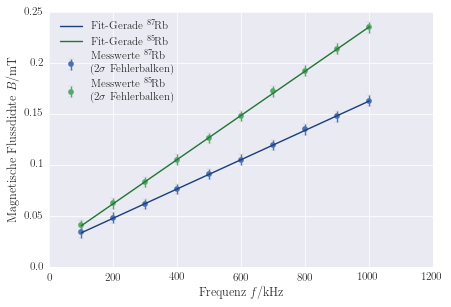

In [18]:
F = np.linspace(100,1000,1e06)


fig, ax = plt.subplots()
ax.set_xlim(0,1200)
ax.set_xlabel(axis_label("Frequenz",sym="f",unit="kHz"))
ax.set_ylabel(axis_label("Magnetische Flussdichte",sym="B",unit="mT"))
axis_scale(1e03,axis="y")

line_P1 = ax.errorbar(resonance_positions["Frequenz kHz"], noms(resonance_positions["Magnetfeld P1"]),
         yerr=2*stds(resonance_positions["Magnetfeld P1"]), label="Messwerte ${}^{87}\!$Rb \n ($2\sigma$ Fehlerbalken)",
                      color=plot_colors[0], marker="o", mec=plot_colors[0], linestyle="")
line_P2 = ax.errorbar(resonance_positions["Frequenz kHz"], noms(resonance_positions["Magnetfeld P2"]),
         yerr=2*stds(resonance_positions["Magnetfeld P2"]), label="Messwerte ${}^{85}\!$Rb \n ($2\sigma$ Fehlerbalken)",
                      color=plot_colors[1],marker="o", mec=plot_colors[1], linestyle="")


ax.plot(F,linear_fct(F*1e3,noms(fit_parameter_P1[0]),noms(fit_parameter_P1[1])),
        label="Fit-Gerade ${}^{87}\!$Rb",color=lighten_color(line_P1[0].get_color(),-0.2))
ax.plot(F,linear_fct(F*1e3,noms(fit_parameter_P2[0]),noms(fit_parameter_P2[1])),
        label="Fit-Gerade ${}^{85}\!$Rb",color=lighten_color(line_P2[0].get_color(),-0.2))
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig(path_graphics+"Resonanzstellen.pdf")

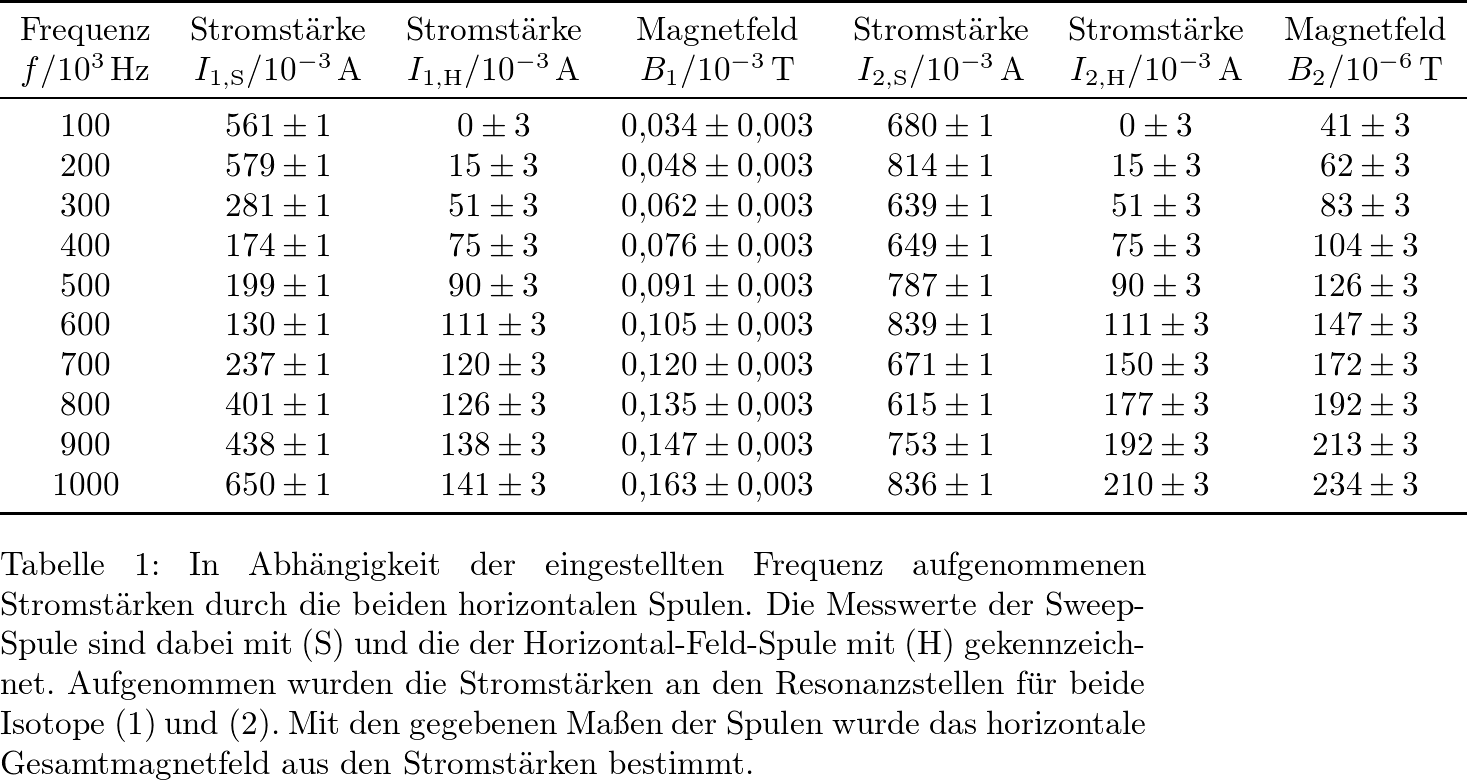

In [19]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption("""In Abhängigkeit der eingestellten Frequenz aufgenommenen Stromstärken durch die beiden horizontalen Spulen.
               Die Messwerte der Sweep-Spule sind dabei mit (S) und die der Horizontal-Feld-Spule mit (H) gekennzeichnet.
               Aufgenommen wurden die Stromstärken an den Resonanzstellen für beide Isotope (1) und (2). Mit den
               gegebenen Maßen der Spulen wurde das horizontale Gesamtmagnetfeld aus den Stromstärken bestimmt.""")
Tab.label("resonanzstellen")
Tab.addColumn(resonance_positions["Frequenz kHz"],title="Frequenz",symbol="f",unit="\\kilo\\hertz")
Tab.addColumn(resonance_positions["SweepStrom P1 0.1V"]*0.1*1000,title="Stromstärke",symbol="I_{1,\\mathrm{S}}",unit="\\milli\\ampere")
Tab.addColumn(resonance_positions["HorizontalStrom P1 0.3V"]*0.3*1000,title="Stromstärke",symbol="I_{1,\\mathrm{H}}",unit="\\milli\\ampere")
Tab.addColumn(resonance_positions["Magnetfeld P1"]*1000,title="Magnetfeld",symbol="B_{1}",unit="\\milli\\tesla")
Tab.addColumn(resonance_positions["SweepStrom P2 0.1V"]*0.1*1000,title="Stromstärke",symbol="I_{2,\\mathrm{S}}",unit="\\milli\\ampere")
Tab.addColumn(resonance_positions["HorizontalStrom P2 0.3V"]*0.3*1000,title="Stromstärke",symbol="I_{2,\\mathrm{H}}",unit="\\milli\\ampere")
Tab.addColumn(resonance_positions["Magnetfeld P2"]*1e6,title="Magnetfeld",symbol="B_{2}",unit="\\micro\\tesla")
Image(Tab.show(ipynb=True,quiet=False),width=800)


In [20]:
#Tab.save(path_table+"Resonanzstellen.tex")

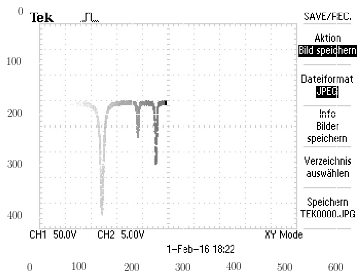

In [21]:
from scipy import ndimage
signal_image=plt.imread(path_graphics+"Signalbild_RF100kHz.JPG")
signal_image=ndimage.rotate(signal_image,90)
plt.imshow(signal_image)



Durch ausmessen der Aplituden erhält man das Verhältnis von P1 zu P2: $R = \frac{4}{7}$
Dieses Verhältnis muss dem Verhältnis des Isotopen Anteils von Rb85 $p_2$ & Rb87 $p_1$ entsprechen.
$R = \frac{p_1}{p_2}$. Daraus folgt mit $p_1 + p_2 = 1$ der Anteil $p_1 = \frac{R}{1+R}$.

In [22]:
def isotope_ratio(R):
    p1 = R/(1+R)
    return p1, 1-p1

In [92]:
height_P1 = unc.ufloat(72,2)
height_P2 = unc.ufloat(126,2)

ratio = height_P1/height_P2 
fraction_P1, fraction_P2 = isotope_ratio(ratio)

print("Verhältnis: ")
print(ratio)
print("\nAnteil von P1: Rb87")
print(fraction_P1)
print("\nAnteil von P2: Rb85")
print(fraction_P2)
#print(fraction_P1/fraction_P2)

print_result(ratio,file="Anteil_Rubidium_Ratio.tex")
print_result(fraction_P1*100,unit="\\percent",file="Anteil_Rubidium_87.tex")
print_result(fraction_P2*100,unit="\\percent",file="Anteil_Rubidium_85.tex")

Verhältnis: 
0.571+/-0.018

Anteil von P1: Rb87
0.364+/-0.007

Anteil von P2: Rb85
0.636+/-0.007


## Quadratischer Zeeman-Effekt

In [24]:
def hyperfine_structure(B,gf,MF,dE):
    linear = gf * const.physical_constants["Bohr magneton"][0] * B
    quadratic = linear**2 * ((1 - 2*MF)/(dE))
    return linear,quadratic

In [117]:
hyperfine_structure_linear_P1, hyperfine_structure_quadratic_P1 = hyperfine_structure(0.25e-03, 1/2,2,4.53e-24)
hyperfine_structure_linear_P2, hyperfine_structure_quadratic_P2 = hyperfine_structure(0.25e-03, 1/3,3,2.01e-24)

In [143]:
print("Zeeman P1: Rb87")
print((hyperfine_structure_linear_P1,))#,description=("U_HF_lin",))
print((hyperfine_structure_quadratic_P1,))#,description=("U_HF_quad",))

print("Zeeman P2: Rb85")
print((hyperfine_structure_linear_P2,))#,description=("U_HF_lin",))
print((hyperfine_structure_quadratic_P2,))#,description=("U_HF_quad",))


print_result(hyperfine_structure_linear_P1,unit="\\joule",file="Zeeman_linear_Rubidium_87.tex")
print_result(hyperfine_structure_quadratic_P1,unit="\\joule",file="Zeeman_quadratisch_Rubidium_87.tex")
print_result(hyperfine_structure_linear_P2,unit="\\joule",file="Zeeman_linear_Rubidium_85.tex")
print_result(hyperfine_structure_quadratic_P2,unit="\\joule",file="Zeeman_quadratisch_Rubidium_85.tex")

Zeeman P1: Rb87
(1.15925121e-27,)
(-8.899757403221617e-31,)
Zeeman P2: Rb85
(7.728341399999999e-28,)
(-1.4857527560933818e-30,)


## Transienten Effekt

In [27]:
def plots(Peak, Num):
    exponential_rising_P1 = pd.read_csv(path_data+"Resonanz_{}_Exp_Anstieg_{}V.csv".format(Peak,Num),skiprows=range(18),usecols=(3,4),names=("Zeit","Spannung"))
    exponential_rising_P1.plot(x="Zeit",y="Spannung")


In [28]:
exponential_rising_P1= pd.read_csv(path_data+"Resonanz_1_Exp_Anstieg_05V.csv",skiprows=range(18),usecols=(3,4),names=("Zeit","Spannung"))


In [29]:
exponential_rising_P2= pd.read_csv(path_data+"Resonanz_2_Exp_Anstieg_06V.csv",skiprows=range(18),usecols=(3,4),names=("Zeit","Spannung"))

In [30]:
exponential_rising_P1.head(2)


,Zeit,Spannung
0,-0.1214,19.8
1,-0.1213,19.8


In [31]:
exponential_rising_P2.head(2)


,Zeit,Spannung
0,-0.1226,1.08
1,-0.1225,1.04


In [32]:
# Einschränkung auf den Anstieg
exponential_rising_P1 = exponential_rising_P1[(exponential_rising_P1["Zeit"]> -0.001)
                                              &(exponential_rising_P1["Zeit"]<0.101)]


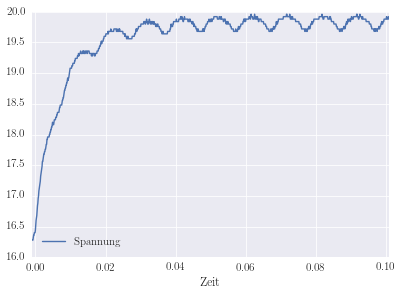

In [33]:
exponential_rising_P1.plot(x="Zeit",y="Spannung")

In [34]:
# Einschränkung auf den Anstieg
exponential_rising_P2 = exponential_rising_P2[(exponential_rising_P2["Zeit"]> -0.001)
                                              &(exponential_rising_P2["Zeit"]<0.101)]


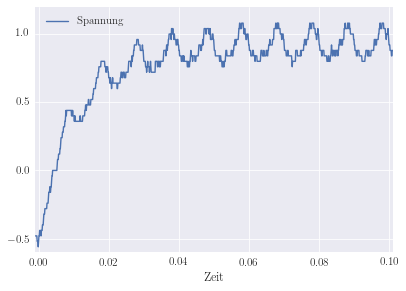

In [35]:
exponential_rising_P2.plot(x="Zeit",y="Spannung")

In [93]:
exp_rise_func = lambda x,a,b,c: a*(1-np.exp(-b*x))+c

popt,pcov = sp.optimize.curve_fit(exp_rise_func,exponential_rising_P1["Zeit"],exponential_rising_P1["Spannung"])

fit_parameter_P1 = fit_errors(popt,pcov)

popt,pcov = sp.optimize.curve_fit(exp_rise_func,exponential_rising_P2["Zeit"],exponential_rising_P2["Spannung"])

fit_parameter_P2 = fit_errors(popt,pcov)


In [97]:
print("Fit Parameter Rb87")
print_errors(fit_parameter_P1,description=("a","b","c"))

print("Fit Parameter Rb85")
print_errors(fit_parameter_P2,description=("a","b","c"))


print_result(fit_parameter_P1[0],unit="\\volt",file="Rubidium_87_Fit_3_a.tex")
print_result(fit_parameter_P1[1],unit="\\second",file="Rubidium_87_Fit_3_b.tex")
print_result(fit_parameter_P1[2],unit="\\volt",file="Rubidium_87_Fit_3_c.tex")
print_result(fit_parameter_P2[0],unit="\\volt",file="Rubidium_85_Fit_3_a.tex")
print_result(fit_parameter_P2[1],unit="\\second",file="Rubidium_85_Fit_3_b.tex")
print_result(fit_parameter_P2[2],unit="\\volt",file="Rubidium_85_Fit_3_c.tex")

Fit Parameter Rb87
a  3.16(2)
b  130.5(1.1)
c  16.66(2)

Fit Parameter Rb85
a  1.39(1)
b  92.8(1.7)
c  -0.47(1)



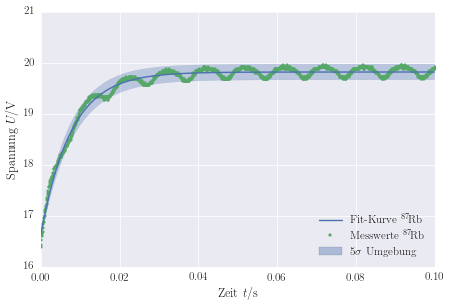

In [99]:
plt.clf()
T = np.linspace(0,0.1,1e3)
U_fit = exp_rise_func(T,noms(fit_parameter_P1[0]),noms(fit_parameter_P1[1]),noms(fit_parameter_P1[2]))
U_fit_upper = exp_rise_func(T,noms(fit_parameter_P1[0])+5*stds(fit_parameter_P1[0]),
                             noms(fit_parameter_P1[1])+5*stds(fit_parameter_P1[1]),
                           noms(fit_parameter_P1[2])+5*stds(fit_parameter_P1[2]))
U_fit_lower = exp_rise_func(T,noms(fit_parameter_P1[0])-5*stds(fit_parameter_P1[0]),
                             noms(fit_parameter_P1[1])-5*stds(fit_parameter_P1[1]),
                           noms(fit_parameter_P1[2])-5*stds(fit_parameter_P1[2]))


fig,ax = plt.subplots()
ax.set_xlim(0,0.1)
ax.set_ylim(16,21)
ax.set_xlabel(axis_label("Zeit",sym="t",unit="s"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="V"))

line_P1 = ax.errorbar(exponential_rising_P1["Zeit"],noms(exponential_rising_P1["Spannung"]),
                      label="Messwerte ${}^{87}\!$Rb ", color=plot_colors[1], 
                      marker="o", mec=plot_colors[1], linestyle="",markersize=3)

ax.plot(T,U_fit,label="Fit-Kurve ${}^{87}\!$Rb",color=plot_colors[0])

sigma = ax.fill_between(T,U_fit_upper,U_fit_lower,color=plot_colors[0],alpha=0.3)
ax.bar(0,0,width=0,color=sigma.get_facecolor()[0][:-1],edgecolor="",label=r"5$\sigma$ Umgebung",alpha=0.4)


ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig(path_graphics+"Exponentieller_Anstieg_5V_Rubidium_87.pdf")

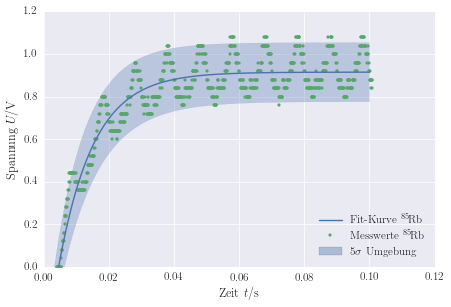

In [100]:
plt.clf()
T = np.linspace(0,0.1,1e3)
U_fit = exp_rise_func(T,noms(fit_parameter_P2[0]),noms(fit_parameter_P2[1]),noms(fit_parameter_P2[2]))
U_fit_upper = exp_rise_func(T,noms(fit_parameter_P2[0])+5*stds(fit_parameter_P2[0]),
                             noms(fit_parameter_P2[1])+5*stds(fit_parameter_P2[1]),
                           noms(fit_parameter_P2[2])+5*stds(fit_parameter_P2[2]))
U_fit_lower = exp_rise_func(T,noms(fit_parameter_P2[0])-5*stds(fit_parameter_P2[0]),
                             noms(fit_parameter_P2[1])-5*stds(fit_parameter_P2[1]),
                           noms(fit_parameter_P2[2])-5*stds(fit_parameter_P2[2]))


fig,ax = plt.subplots()
ax.set_xlim(0,0.12)
ax.set_ylim(0,1.2)
ax.set_xlabel(axis_label("Zeit",sym="t",unit="s"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="V"))

line_P1 = ax.errorbar(exponential_rising_P2["Zeit"],noms(exponential_rising_P2["Spannung"]),
                      label="Messwerte ${}^{85}\!$Rb ", color=plot_colors[1], 
                      marker="o", mec=plot_colors[1], linestyle="",markersize=3)

ax.plot(T,U_fit,label="Fit-Kurve ${}^{85}\!$Rb",color=plot_colors[0])

sigma = ax.fill_between(T,U_fit_upper,U_fit_lower,color=plot_colors[0],alpha=0.3)
ax.bar(0,0,width=0,color=sigma.get_facecolor()[0][:-1],edgecolor="",label=r"5$\sigma$ Umgebung",alpha=0.4)


ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig(path_graphics+"Exponentieller_Anstieg_V6_Rubidium_85.pdf")

In [104]:
period_lenghts = pd.read_csv(path_data+"Periodendauern.csv")
period_lenghts.columns

Index(['RFSpannung V', 'Zeitdifferenz P1 ms', 'Perioden P1',
       'Zeitdifferenz P2 ms', 'Perioden P2'],
      dtype='object')

In [105]:
period_lenghts.head(1)

,RFSpannung V,Zeitdifferenz P1 ms,Perioden P1,Zeitdifferenz P2 ms,Perioden P2
0,1,9,3,0.96,1


In [106]:
period_lenghts["Zeitdifferenz P1 ms"] = unp.uarray(period_lenghts["Zeitdifferenz P1 ms"],[0.1])
period_lenghts["Zeitdifferenz P2 ms"] = unp.uarray(period_lenghts["Zeitdifferenz P2 ms"],[0.1])
#period_lenghts["Perioden P1"] = unp.uarray(period_lenghts["Perioden P1"],np.sqrt(period_lenghts["Perioden P1"]))
#period_lenghts["Perioden P2"] = unp.uarray(period_lenghts["Perioden P2"],np.sqrt(period_lenghts["Perioden P2"]))

In [107]:
period_lenghts.head(1)

,RFSpannung V,Zeitdifferenz P1 ms,Perioden P1,Zeitdifferenz P2 ms,Perioden P2
0,1,9.00+/-0.10,3,0.96+/-0.10,1


In [108]:
period_lenghts["Periodendauer P1"] = period_lenghts["Zeitdifferenz P1 ms"]/period_lenghts["Perioden P1"]
period_lenghts["Periodendauer P2"] = period_lenghts["Zeitdifferenz P2 ms"]/period_lenghts["Perioden P2"]

In [109]:
period_lenghts.head()

,RFSpannung V,Zeitdifferenz P1 ms,Perioden P1,Zeitdifferenz P2 ms,Perioden P2,Periodendauer P1,Periodendauer P2
0,1,9.00+/-0.10,3,0.96+/-0.10,1,3.000+/-0.033,0.96+/-0.10
1,2,6.40+/-0.10,4,2.52+/-0.10,2,1.600+/-0.025,1.26+/-0.05
2,3,6.40+/-0.10,6,4.28+/-0.10,4,1.067+/-0.017,1.070+/-0.025
3,4,5.00+/-0.10,7,2.04+/-0.10,3,0.714+/-0.014,0.680+/-0.033
4,5,5.20+/-0.10,8,4.52+/-0.10,7,0.650+/-0.013,0.646+/-0.014


In [110]:
#Fit der Messwerte
hyperbolic_fct = lambda x,a,b,c: a + b/(x-c) 

popt, pcov = sp.optimize.curve_fit(hyperbolic_fct, period_lenghts["RFSpannung V"],
                                   noms(period_lenghts["Periodendauer P1"]),p0=(0.1,1,0))#,sigma=noms(period_lenghts["Periodendauer P1"]))
fit_parameter_P1 = fit_errors(popt,pcov)

popt, pcov = sp.optimize.curve_fit(hyperbolic_fct, period_lenghts["RFSpannung V"],
                                   noms(period_lenghts["Periodendauer P2"]),p0=(0.1,1,0))#,sigma=noms(period_lenghts["Periodendauer P2"]))
fit_parameter_P2 = fit_errors(popt,pcov)


popt, pcov = sp.optimize.curve_fit(hyperbolic_fct, period_lenghts["RFSpannung V"][1:],
                                   noms(period_lenghts["Periodendauer P2"][1:]),p0=(0.1,1,0))#,sigma=noms(period_lenghts["Periodendauer P2"][1:]))
fit_parameter_leftout_P2 = fit_errors(popt,pcov)


In [111]:
print("Fit Parameter Rb87")
print_errors(fit_parameter_P1,description=("a","b","c"))

print("Fit Parameter Rb85")
print_errors(fit_parameter_P2,description=("a","b","c"))

print("Fit Parameter Rb85")
print_errors(fit_parameter_leftout_P2,description=("a","b","c"))

print_result(fit_parameter_P1[0]/1000,unit="\\second",file="Rubidium_87_Fit_2_a.tex")
print_result(fit_parameter_P1[1]/1000,unit="\\volt\\second",file="Rubidium_87_Fit_2_b.tex")
print_result(fit_parameter_P1[2],unit="\\volt",file="Rubidium_87_Fit_2_c.tex")

print_result(fit_parameter_P2[0]/1000,unit="\\second",file="Rubidium_85_Fit_2_a.tex")
print_result(fit_parameter_P2[1]/1000,unit="\\volt\\second",file="Rubidium_85_Fit_2_b.tex")
print_result(fit_parameter_P2[2],unit="\\volt",file="Rubidium_85_Fit_2_c.tex")

print_result(fit_parameter_leftout_P2[0]/1000,unit="\\second",file="Rubidium_85_Fit_2_Ausgelassen_a.tex")
print_result(fit_parameter_leftout_P2[1]/1000,unit="\\volt\\second",file="Rubidium_85_Fit_2_Ausgelassen_b.tex")
print_result(fit_parameter_leftout_P2[2],unit="\\volt",file="Rubidium_85_Fit_2_Ausgelassen_c.tex")

Fit Parameter Rb87
a  -0.17(6)
b  4.0(4)
c  -0.3(1)

Fit Parameter Rb85
a  -2.5(5.7)
b  0.9(3.4)e+02
c  -2.4(5.3)e+01

Fit Parameter Rb85
a  -0.2(2)
b  5.7(2.3)
c  -1.8(1.1)



In [116]:
ratio_b = fit_parameter_P2[1]/fit_parameter_P1[1]
ratio_b_leftout = fit_parameter_leftout_P2[1]/fit_parameter_P1[1]


print("Verhältnis der Parameter b")
print_errors((ratio_b,),description=("r",))

print("Verhältnis der Parameter b Ausgelassen")
print_errors((ratio_b_leftout,),description=("r",))

print_result(ratio_b,file="Verhälnis_Fit_2_b.tex")
print_result(ratio_b_leftout,file="Verhälnis_Fit_2_Ausgelassen_b.tex")

Verhältnis der Parameter b
r  2.3(8.5)e+01

Verhältnis der Parameter b Ausgelassen
r  1.4(6)



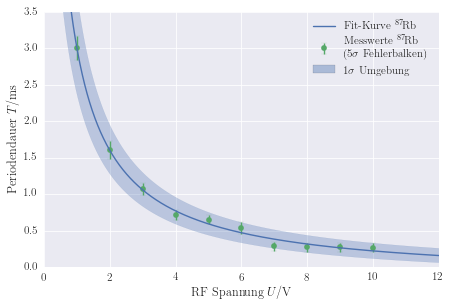

In [113]:
U = np.linspace(0,12,1e03)
T_fit = hyperbolic_fct(U,noms(fit_parameter_P1[0]),noms(fit_parameter_P1[1]),noms(fit_parameter_P1[2]))
T_fit_upper = hyperbolic_fct(U,noms(fit_parameter_P1[0])+stds(fit_parameter_P1[0]),
                             noms(fit_parameter_P1[1])+stds(fit_parameter_P1[1]),
                             noms(fit_parameter_P1[2])+stds(fit_parameter_P1[2]))
T_fit_lower = hyperbolic_fct(U,noms(fit_parameter_P1[0])-stds(fit_parameter_P1[0]),
                             noms(fit_parameter_P1[1])-stds(fit_parameter_P1[1]),
                             noms(fit_parameter_P1[2])-stds(fit_parameter_P1[2]))


fig,ax = plt.subplots()
ax.set_xlim(0,12)
ax.set_ylim(0,3.5)
ax.set_xlabel(axis_label("RF Spannung",sym="U",unit="V"))
ax.set_ylabel(axis_label("Periodendauer",sym="T",unit="ms"))

line_P1 = ax.errorbar(period_lenghts["RFSpannung V"],noms(period_lenghts["Periodendauer P1"]),
            yerr = 5*stds(period_lenghts["Periodendauer P1"]),label="Messwerte ${}^{87}\!$Rb \n ($5\sigma$ Fehlerbalken)",
            color=plot_colors[1], marker="o", mec=plot_colors[1], linestyle="")

ax.plot(U,T_fit,label="Fit-Kurve ${}^{87}\!$Rb",color=plot_colors[0])
sigma = ax.fill_between(U,T_fit_upper,T_fit_lower,color=plot_colors[0],alpha=0.3)
ax.bar(0,0,width=0,color=sigma.get_facecolor()[0][:-1],edgecolor="",label=r"1$\sigma$ Umgebung",alpha=0.4)


ax.legend(loc="upper right")
fig.tight_layout()
fig.savefig(path_graphics+"Transienteneffekt_Rubidium_87.pdf")

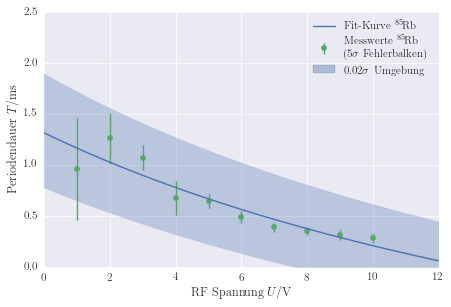

In [114]:
U = np.linspace(0,12,1e03)

T_fit = hyperbolic_fct(U,noms(fit_parameter_P2[0]),noms(fit_parameter_P2[1]),noms(fit_parameter_P2[2]))
a = 0.02
T_fit_upper = hyperbolic_fct(U,noms(fit_parameter_P2[0])+a*stds(fit_parameter_P2[0]),
                             noms(fit_parameter_P2[1])+a*stds(fit_parameter_P2[1]),
                             noms(fit_parameter_P2[2])+a*stds(fit_parameter_P2[2]))
T_fit_lower = hyperbolic_fct(U,noms(fit_parameter_P2[0])-a*stds(fit_parameter_P2[0]),
                             noms(fit_parameter_P2[1])-a*stds(fit_parameter_P2[1]),
                             noms(fit_parameter_P2[2])-a*stds(fit_parameter_P2[2]))

fig,ax = plt.subplots()
ax.set_xlim(0,12)
ax.set_ylim(0,2.5)
ax.set_xlabel(axis_label("RF Spannung",sym="U",unit="V"))
ax.set_ylabel(axis_label("Periodendauer",sym="T",unit="ms"))

line_P2 = ax.errorbar(period_lenghts["RFSpannung V"],noms(period_lenghts["Periodendauer P2"]),
            yerr=5*stds(period_lenghts["Periodendauer P2"]),label="Messwerte ${}^{85}\!$Rb \n ($5\sigma$ Fehlerbalken)",
            color=plot_colors[1], marker="o", mec=plot_colors[1], linestyle="")

sigma = ax.fill_between(U,T_fit_upper,T_fit_lower,color=plot_colors[0],alpha=0.3)
ax.bar(0,0,width=0,color=sigma.get_facecolor()[0][:-1],edgecolor="",label=r"0.02$\sigma$ Umgebung",alpha=0.4)

ax.plot(U,T_fit,label="Fit-Kurve ${}^{85}\!$Rb",color=plot_colors[0])


#ax.plot(U,hyperbolic_fct(U,noms(fit_parameter_leftout_P2[0]),noms(fit_parameter_leftout_P2[1]),noms(fit_parameter_leftout_P2[2])),
#       label="Fit-Kurve ${}^{87}\!$Rb",color=lighten_color(line_P2[0].get_color(),-0.2))

ax.legend(loc="upper right")
fig.tight_layout()
fig.savefig(path_graphics+"Transienteneffekt_Rubidium_85.pdf")

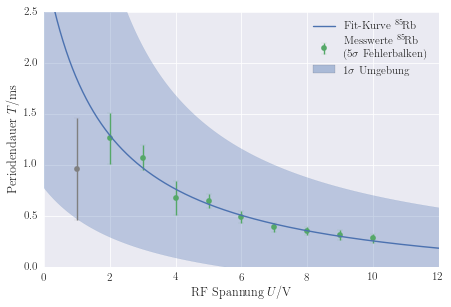

In [115]:
U = np.linspace(0,12,1e03)

T_fit = hyperbolic_fct(U,noms(fit_parameter_leftout_P2[0]),noms(fit_parameter_leftout_P2[1]),
                       noms(fit_parameter_leftout_P2[2]))
a = 1
T_fit_upper = hyperbolic_fct(U,noms(fit_parameter_leftout_P2[0])+a*stds(fit_parameter_leftout_P2[0]),
                             noms(fit_parameter_leftout_P2[1])+a*stds(fit_parameter_leftout_P2[1]),
                             noms(fit_parameter_leftout_P2[2])+a*stds(fit_parameter_leftout_P2[2]))
T_fit_lower = hyperbolic_fct(U,noms(fit_parameter_leftout_P2[0])-a*stds(fit_parameter_leftout_P2[0]),
                             noms(fit_parameter_leftout_P2[1])-a*stds(fit_parameter_leftout_P2[1]),
                             noms(fit_parameter_leftout_P2[2])-a*stds(fit_parameter_leftout_P2[2]))

fig,ax = plt.subplots()
ax.set_xlim(0,12)
ax.set_ylim(0,2.5)
ax.set_xlabel(axis_label("RF Spannung",sym="U",unit="V"))
ax.set_ylabel(axis_label("Periodendauer",sym="T",unit="ms"))

ax.errorbar(period_lenghts["RFSpannung V"][0],noms(period_lenghts["Periodendauer P2"][0]),
            yerr=5*stds(period_lenghts["Periodendauer P2"][0]),
            color="gray", marker="o", mec="gray", linestyle="")

line_P2 = ax.errorbar(period_lenghts["RFSpannung V"][1:],noms(period_lenghts["Periodendauer P2"][1:]),
            yerr=5*stds(period_lenghts["Periodendauer P2"][1:]),label="Messwerte ${}^{85}\!$Rb \n ($5\sigma$ Fehlerbalken)",
            color=plot_colors[1], marker="o", mec=plot_colors[1], linestyle="")

sigma = ax.fill_between(U,T_fit_upper,T_fit_lower,color=plot_colors[0],alpha=0.3)
ax.bar(0,0,width=0,color=sigma.get_facecolor()[0][:-1],edgecolor="",label=r"1$\sigma$ Umgebung",alpha=0.4)

ax.plot(U,T_fit,label="Fit-Kurve ${}^{85}\!$Rb",color=plot_colors[0])

ax.legend(loc="upper right")
fig.tight_layout()
fig.savefig(path_graphics+"Transienteneffekt_ausgelassen_Rubidium_85.pdf")

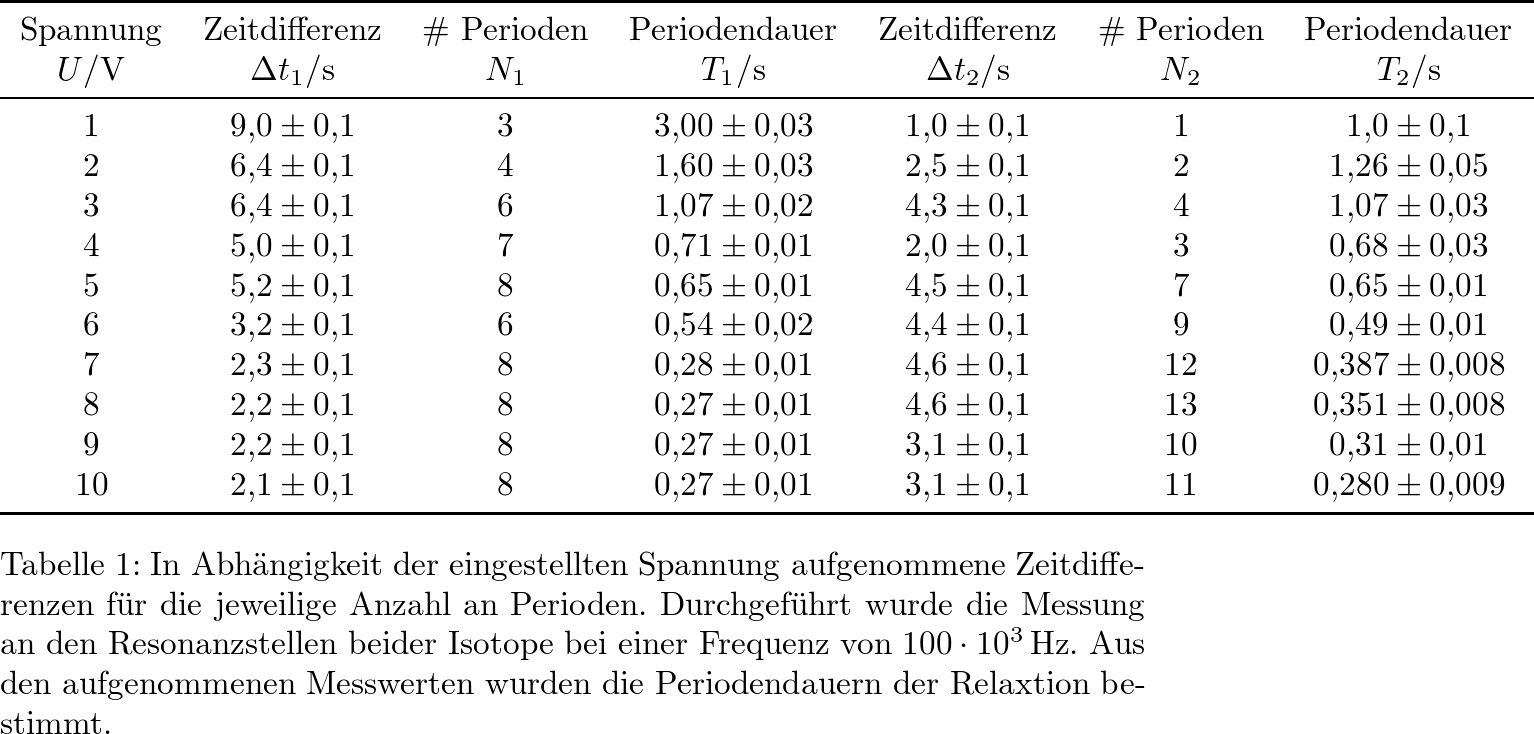

In [52]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption("""In Abhängigkeit der eingestellten Spannung aufgenommene Zeitdifferenzen für die jeweilige Anzahl an Perioden.
               Durchgeführt wurde die Messung an den Resonanzstellen beider Isotope bei einer Frequenz von \\SI{100}{\\kilo\\hertz}.
               Aus den aufgenommenen Messwerten wurden die Periodendauern der Relaxtion bestimmt.""")
Tab.label("periodendauern")
Tab.addColumn([int(u) for u in period_lenghts["RFSpannung V"]],title="Spannung",symbol="U",unit="\\volt")
Tab.addColumn(period_lenghts["Zeitdifferenz P1 ms"],title="Zeitdifferenz",symbol="\\Delta t_{1}",unit="\\second")
Tab.addColumn(period_lenghts["Perioden P1"],title="\\# Perioden",symbol="N_{1}",unit=None)
Tab.addColumn(period_lenghts["Periodendauer P1"],title="Periodendauer",symbol="T_{1}",unit="\\second")
Tab.addColumn(period_lenghts["Zeitdifferenz P2 ms"],title="Zeitdifferenz",symbol="\\Delta t_{2}",unit="\\second")
Tab.addColumn(period_lenghts["Perioden P2"],title="\\# Perioden",symbol="N_{2}",unit=None)
Tab.addColumn(period_lenghts["Periodendauer P2"],title="Periodendauer",symbol="T_{2}",unit="\\second")
Image(Tab.show(ipynb=True,quiet=False))

In [53]:
#Tab.save(path_table+"Periodendauern.tex")

### Tests

In [54]:

def nuclear_spin(gf,gj):
    B= (2*gf/gj)
    print(B)
    return - ((2*B-1)/(2*B)) + np.sqrt(((2*B-1)/(2*B))**2 - (3/4)*((B-2)/B)), -1/B + np.sqrt((1/B**2) + (1/(2*B)) - 1/4)

In [55]:
nuclear_spin(1/3,2)

0.3333333333333333


(2.5, 0.20156211871642427)